# [AI 이노베이션 스퀘어] 12기 고급 시각반
- github: https://github.com/hysKim1/AI_Vision
    - [파이썬 공식문서]https://docs.python.org/ko/3/
    - [Numpy 공식문서]https://numpy.org/devdocs/
    - [ML]https://developers.google.com/machine-learning/crash-course/ml-intro?hl=ko
    - [DL]https://www.tensorflow.org/?hl=ko
      
---
* [History](#History)
* [Object Detection2 ](#Object-Detection2 )
    * [Fast R-CNN ](#Fast-R-CNN )

---
## History

- DE 2012  머신러닝을 사용하지 않는 SIFT, Hog

- CL 2012:Alexnet
- DE 2013: R-CNN
  - Selctive Search

- CL 2013: ZF
- DE 2014: SPPNEt
    - Spatial Pyramid Pooling layer

- CL 2014: GooLenNet, VGG
- DE 2015: Fast R-CNN

- CL 2015:Resnet
- DE 2016 Faster R-CNN
    - single-stage method: RPN

-  경량화

--- 
## Object Detection2

- ICCV15에서 저자 Ross Girshick가 논문을 대중에게 소개한 tutorial ppt
- localization: 사람 인지 구조와 달라서 능가하기 어려움

R-CNN 문제점
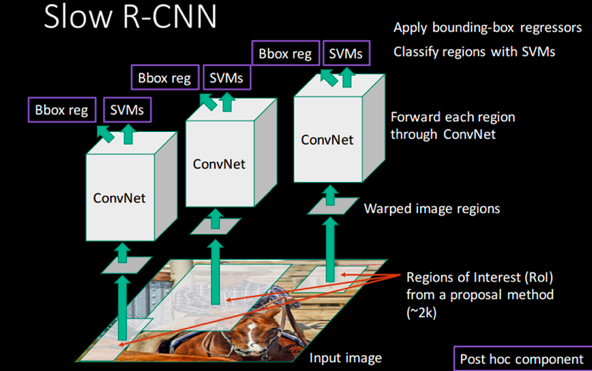
- 이전에는 computer vision에서는 머신러닝 사용하지 않은 알고리즘이 좋았었으나 R-CNN에서 convolution 사용한 이후에는 성능이 훨씬 좋아짐
-  Multi-Stage model :2000개 RoI(객체 후보 영역)마다 각각 CNN, SVM classifier, b-box regressor 세가지 모델을 모두 훈련시키기 어렵고 속도가 느림
- SVM. b-box regressor 학습을 위해서 feature추출하고 디스크에 저장


Spp-net문제점
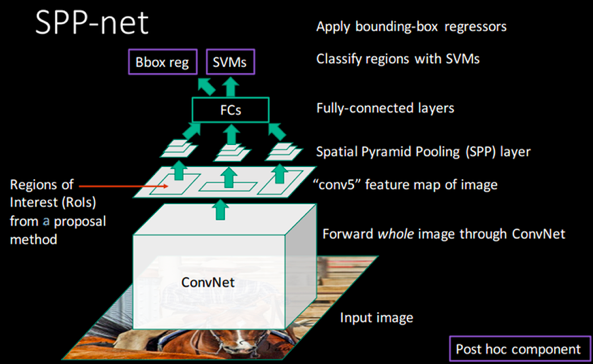
- SPP-net의 SPP로 convolution연산 공유해서 속도 빨라짐
- feature caching 디스크 공간에 저장됨

## Fast R-CNN

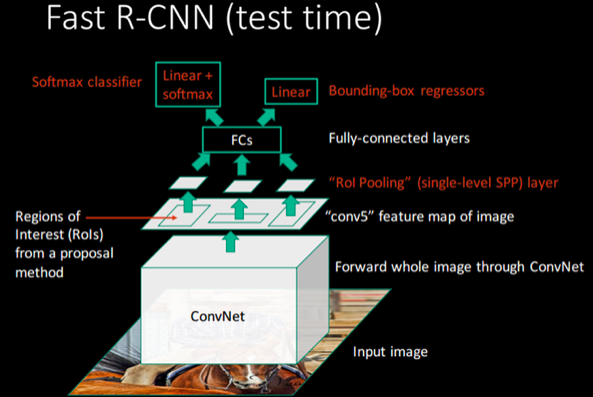
- SPP-net처럼 이미지 전체를 한번에 처리, 결과 공유
- pooling layer에서 다양한 크기의 RoI영역이 FClayer들어갈수 있도록 크기 조정


- **RoI( Region of Interest) Pooling**
    -  7x7 single-level SPP layer
        - SPP layer 의  1,2,4 계층적 분할하여 피라미드 형태가 더 좋을거라 생각했지만 한번에 7x7 pooling 속도 빠름(병목현상 줄임)    
    - selective search에서 찾은 bounding box를 CNN을 통해서 유지하고, 최종 feature map으로 부터 해당 영역을 추출하여 pooling 시간을 단축

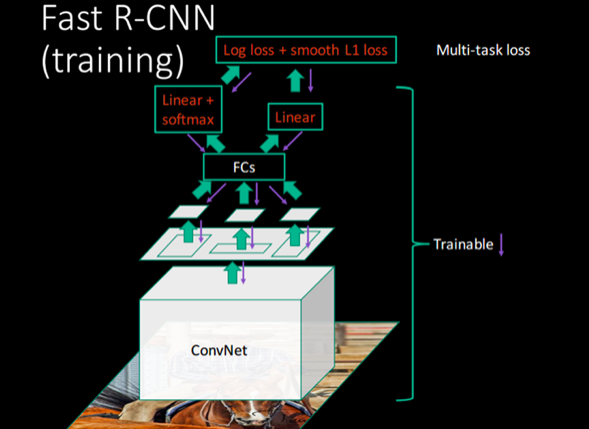

- one network traind in one stage
      -  각각의 모델을 **한번에(single stage) 학습** 할 수 있도록 통합한 multi-task loss  
- softmax classifier + b-box regressors 하나의 네트워크에 포함시켜  동시에 loss 최소화
      - 아직 selective search 사용하므로 완전한 단일 모델을 아님 
  - Log loss + smooth L1 loss 최소화

- Higher Detection Quatlity
    - 7x7 이 항상 좋지 않으나 R-CNN 비교해서 항상 좋음(VGG)
- Efficient SGD steps
       - receptive field가 전체 이미지인 경우 연산량 많음
       - **hierachial sampling** :  mini batches 구성시 빠르게 학습
       - 2개 이미지에서 각 이미지로 부터 64개의 RoI 지정 
       
- No disk storage required
    - 그당시 메모리 작아서 hard disk에서 불러왔었음
    - 특성이 다 공유 되서 conv 특성에 반영되어서 동시에 가능

In [2]:
import tensorflow as tf

### 레이어 커스터마이징 
- spatial pyramid pooilng & RoI pooling 구현 
- Layer 상속

- __init__
- call:  build, __call__ 

Custom layers 참고: https://www.tensorflow.org/tutorials/customization/custom_layers?hl=ko
- tf 제공하지 않는 레이어 커스터마이징
- SPP,RoI layer 참고 : https://github.com/yhenon/keras-spp

In [ ]:
#필수 구성
class ROILayer (tf.keras.layers.Layer): 
  def __init__ (self,*arg,**kwargs):
    super().__init__(*arg,**kwargs)
  def call(self, x):
    pass 

In [3]:
#기본 구성
class ROILayer (tf.keras.layers.Layer): 
  def __init__ (self,*arg,**kwargs): #초기화  
    super().__init__(*arg,**kwargs)

  #오버라이딩
    
  def build(self, input_shape):                 #input shape
    pass

  def compute_output_shape(self, input_shape):  # output shape
    pass 

  def call(self, x):   
    pass 

  def get_config(self): #다른사람들이 구성이 어떻게 되었는지 확인용 
    pass

In [3]:
vgg=tf.keras.applications.VGG16()
vgg.get_config() # vgg 구성

553467904/553467096 [==============================] - 3s 0us/step


{'input_layers': [['input_1', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 224, 224, 3),
    'dtype': 'float32',
    'name': 'input_1',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_1'},
  {'class_name': 'Conv2D',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'dtype': 'float32',
    'filters': 64,
    'groups': 1,
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'kernel_regularizer': None,
    'kernel_size': (3, 3),
    'name': 'block1_conv1',
    'padding': 'same',
    'strides': (1, 1),
    'trainable': True,
    'use_bias': True},
   'inbound_nodes': [[['input_1', 0, 0, {}]]],
   'name': 'block1_conv1'},
  {'class

- backend
    -  thiano: channel first:chw
    -  tf : channel last :hwc

In [12]:
#input, output 먼저 맞춰놓기 

class ROILayer (tf.keras.layers.Layer): 
  def __init__ (self,pool_list,num_rois,**kwargs): #초기값 설정  
    super().__init__(**kwargs)
    self.pool_list=pool_list  # pooling regions 갯수 리스트 입력 받음 [1,2,3]
    self.num_rois=num_rois    # RoIs 갯수
    #채널당 outputs
    self.num_outputs_per_channel=sum([i*i for i in pool_list]) # [1x1, 2x2 ,3x3...]


  def build(self, input_shape):     #input shape

    # 채널수 초기화(리턴 없음)  :  (0HWC) Channel Last
    self.nb_channels= input_shape[0][3]

  def compute_output_shape(self, input_shape):  # output shape
    #계산된것 확인; (None,num_rois, 총 output 갯수 )
    return None,self.num_rois,self.nb_channels * self.num_outputs_per_channel 

  def call(self, x):   #핵심 :build(한 번만 불림), __call__
    #이미지 Partition 

    # num_rois: R-CNN에서는 selective serach로 찾은 후보영역 갯수

    # SPPNet: convolution feature map activation 영역== 이미지 특징

    img=x[0] # 3 or 4차원 image
    rois=x[1]# feature map/이미지 당 SS/RoI 갯수

    for i in range(self.num_rois): 
      # roi pooling layer 전체 이미지에서 b-box영역(4개 좌표값)

      x=rois[0,i,0]
      y=rois[0,i,1]
      w=rois[0,i,2]
      h=rois[0,i,3]
    
      # pool_list 기반으로 각 RoIs영역 돌다다니면서 분할
      row_length=[w / j for j in self.pool_list]   
      col_length=[h / j for j in self.pool_list]
      
      #분할한 값중에서 max pooling 
            
      self.output= []

      for i in pool_region: #max pooling 
        for j in i:
          pool_val=K.max() #backend
          self.output.append(pool_val) #결과값 저장
            
       self.output.append(pool_val) 
  def get_config(self): #구성요소 {}
    original= super().get_config()  #부모의 get_config에 인자 추가 
    my_config = {'pool_list': self.pool_list, 'num_rois':self.num_rois}
    original.update(my_config)      #mutable
    return original

In [ ]:
rl=ROILyer([1,2,4],3)#3개 pooling

In [7]:
#dictionary 추가 방법
x={'a':1}
y={'b':2}
x.update(y) #mutable방식으로 변경
x

{'a': 1, 'b': 2}

In [10]:
dict(list(x.items())+list(y.items()))

{'a': 1, 'b': 2}